In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
random_state = 42

## Introduction to the Problem

In the high-stakes world of battle royale games like PlayerUnknown's Battlegrounds (PUBG), every match is a new story. While winning is the ultimate goal, a player's experience is defined by more than just their final rank. A player who gets ten kills but is eliminated early due to bad luck has a vastly different—and likely more frustrating—experience than a player who hides and survives to the end with zero kills.

This project tackles that nuanced problem. Instead of predicting long-term churn, we aim to identify **in-match frustration**.

**The central question is: Can we use a player's in-match actions (kills, damage, distance traveled) to predict their expected final placement, and then use the *error* in that prediction to quantify how frustrating their match was?**

By answering this, we can create a "Frustration Score" to identify players who are performing well but not being rewarded. This could be used by game developers to fine-tune game balance or even by players themselves to understand their own performance beyond the final scoreboard.

## The Dataset

To answer our question, we are using data from the **PUBG Finish Placement Prediction** competition on Kaggle. This dataset contains detailed statistics from over 4 million individual player performances in PUBG matches.

Link to project: [PUBG Finish Placement Prediction](https://www.kaggle.com/c/pubg-finish-placement-prediction/data)

*To run this notebook, please download the `train_V2.csv` file from the link above and place it in the root directory of this project.*

*Note: The data file is not included in this repository due to its large size and to respect the data source's distribution policy.*

**Target Variable** Our primary goal is to predict a player's final placement. Therefore, our target variable ($y$) is:
* **`winPlacePerc`**: A continuous value from **0.0** (finished last) to **1.0** (won the match). It represents the player's rank as a percentile, providing a standardized measure of success across matches with different numbers of players.

**Features** 
From the many columns available, we will select a core set of features that best represent a player's skill, effort, and strategy during a match.

| Feature Name | Description | Data Type | Type |
| :--- | :--- | :--- | :--- |
| **`kills`** | Number of enemy players killed. | Numerical | Original |
| **`assists`** | Number of times a player assisted a teammate in a kill. | Numerical | Original |
| **`DBNOs`** | Number of times a player knocked down an enemy ("Down But Not Out"). | Numerical | Original |
| **`damageDealt`** | Total damage inflicted on opponents. | Numerical | Original |
| **`headshotKills`** | Number of kills that were headshots. | Numerical | Original |
| **`killStreaks`** | The player's longest kill streak in the match. | Numerical | Original |
| **`longestKill`** | The distance of the player's longest kill. | Numerical | Original |
| **`walkDistance`** | Total distance traveled on foot. | Numerical | Original |
| **`rideDistance`** | Total distance traveled in a vehicle. | Numerical | Original |
| **`swimDistance`** | Total distance traveled by swimming. | Numerical | Original |
| **`revives`** | Number of times a player revived a teammate. | Numerical | Original |
| **`heals`** | Number of healing items used. | Numerical | Original |
| **`boosts`** | Number of boosting items used. | Numerical | Original |
| **`weaponsAcquired`** | Number of weapons picked up. | Numerical | Original |
| **`teamKills`** | Number of times a player killed a teammate. | Numerical | Original |
| **`matchType`** | The type of match (e.g., 'squad-fpp', 'duo', 'solo'). | Categorical | Original |
| **`totalDistance`** | The sum of all travel distances (walk, ride, swim). | Numerical | Engineered |
| **`headshotRate`** | The percentage of a player's kills that were headshots. | Numerical | Engineered |
| **`itemsUsed`** | The combined total of healing and boosting items used. | Numerical | Engineered |
| **`Id`, `groupId`, `matchId`** | Unique identifiers for player, group, and match. | Categorical | Original |
| **`killPlace`** | Player's in-match rank based on number of kills. | Numerical | Original |
| **`killPoints`, `rankPoints`, `winPoints`** | Deprecated ranking points from the game's old system. | Numerical | Original |

## Data Loading and Initial Overview

In [3]:
# IMPORTANT NOTE: Our dataset contains more that 4 million rows
# so it may take a while to load it
# to speed loading times, analysts may consider using a sample of the dataset only
df = pd.read_csv('train_V2.csv')

In [4]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [5]:
print("Rows: ", df.shape[0], "\nColumns: ", df.shape[1])

Rows:  4446966 
Columns:  29


In [6]:
df.dtypes

Id                  object
groupId             object
matchId             object
assists              int64
boosts               int64
damageDealt        float64
DBNOs                int64
headshotKills        int64
heals                int64
killPlace            int64
killPoints           int64
kills                int64
killStreaks          int64
longestKill        float64
matchDuration        int64
matchType           object
maxPlace             int64
numGroups            int64
rankPoints           int64
revives              int64
rideDistance       float64
roadKills            int64
swimDistance       float64
teamKills            int64
vehicleDestroys      int64
walkDistance       float64
weaponsAcquired      int64
winPoints            int64
winPlacePerc       float64
dtype: object

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
assists,4446966.0,0.233815,0.588573,0.0,0.0,0.0000,0.000000,22.0
boosts,4446966.0,1.106908,1.715794,0.0,0.0,0.0000,2.000000,33.0
damageDealt,4446966.0,130.717138,170.780621,0.0,0.0,84.2400,186.000000,6616.0
DBNOs,4446966.0,0.657876,1.145743,0.0,0.0,0.0000,1.000000,53.0
headshotKills,4446966.0,0.226820,0.602155,0.0,0.0,0.0000,0.000000,64.0
heals,4446966.0,1.370147,2.679982,0.0,0.0,0.0000,2.000000,80.0
killPlace,4446966.0,47.599350,27.462937,1.0,24.0,47.0000,71.000000,101.0
killPoints,4446966.0,505.006042,627.504896,0.0,0.0,0.0000,1172.000000,2170.0
kills,4446966.0,0.924783,1.558445,0.0,0.0,0.0000,1.000000,72.0
killStreaks,4446966.0,0.543955,0.710972,0.0,0.0,0.0000,1.000000,20.0


In [8]:
df.isna().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

## Exploratory Data Analysis (EDA)

Let us start by observing the relationships of our features with each other and the target. That will help us get an early understanding of the behavior of our data. 

In [9]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr = df[num_cols].corr()
corr_with_target = corr['winPlacePerc'].drop('winPlacePerc').sort_values(key=abs, ascending=False)

### Distribution Analysis (Univariate)

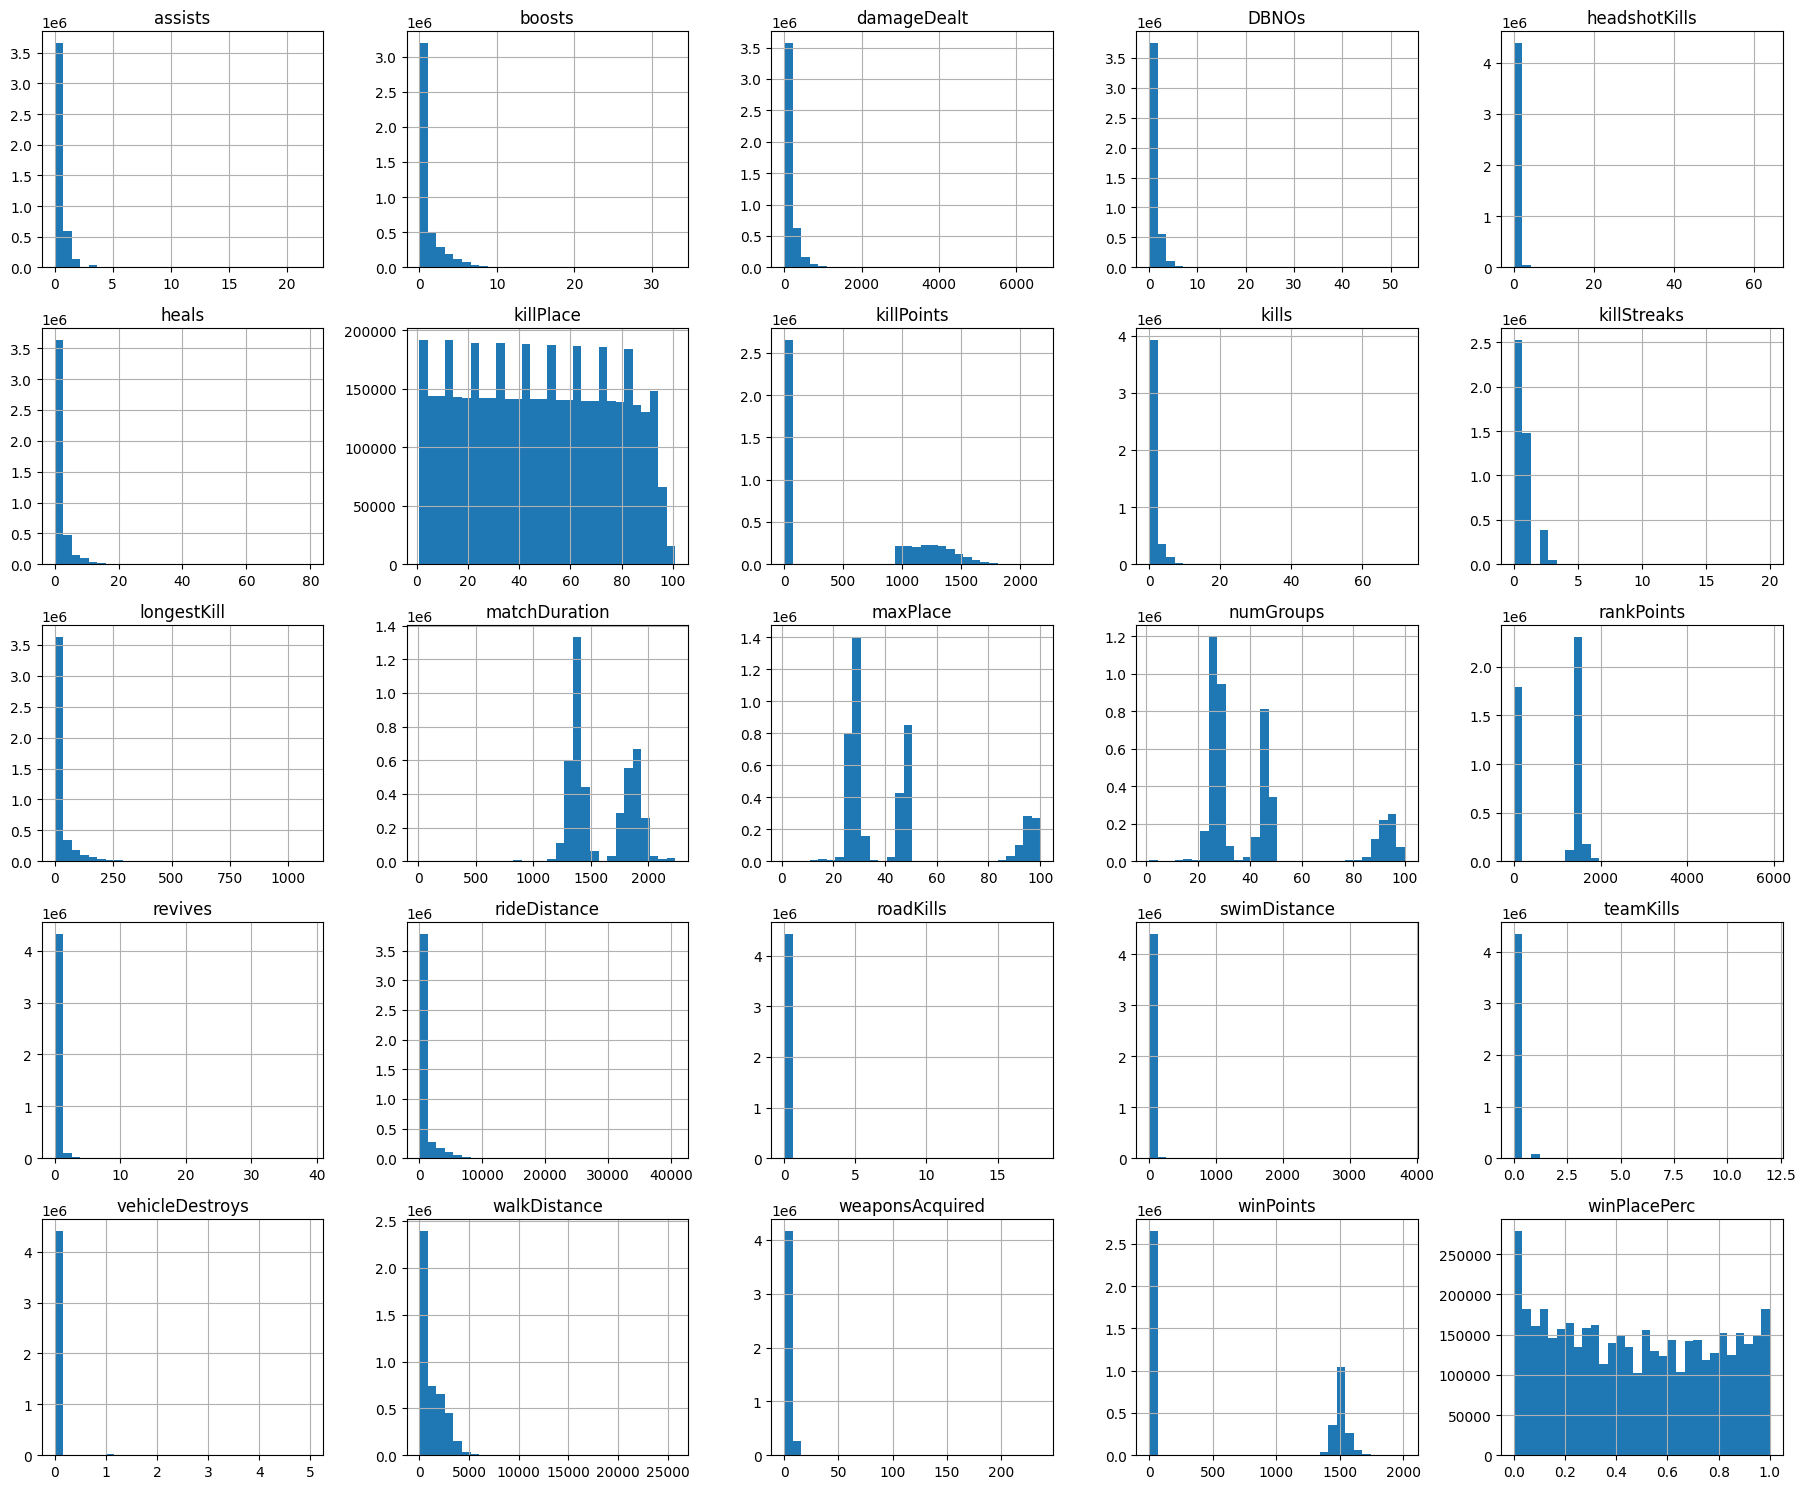

In [10]:
num_cols = df.select_dtypes(include='number').columns
df[num_cols].hist(figsize=(18, 15), bins=30)
plt.tight_layout()
plt.show()

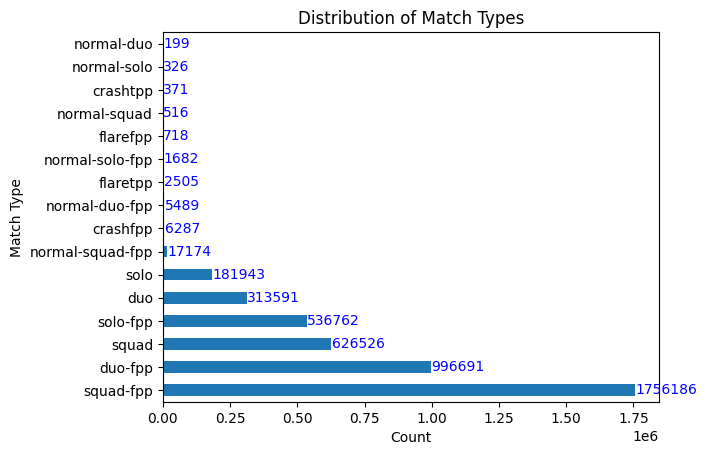

In [11]:
df['matchType'].value_counts().plot(kind='barh')
for i, v in enumerate(df['matchType'].value_counts()):
    plt.text(v + 1000, i, str(v), color='blue', va='center')
plt.xlabel('Count')
plt.ylabel('Match Type')
plt.title('Distribution of Match Types')
plt.show()

### Distribution Analysis (Bivariate)

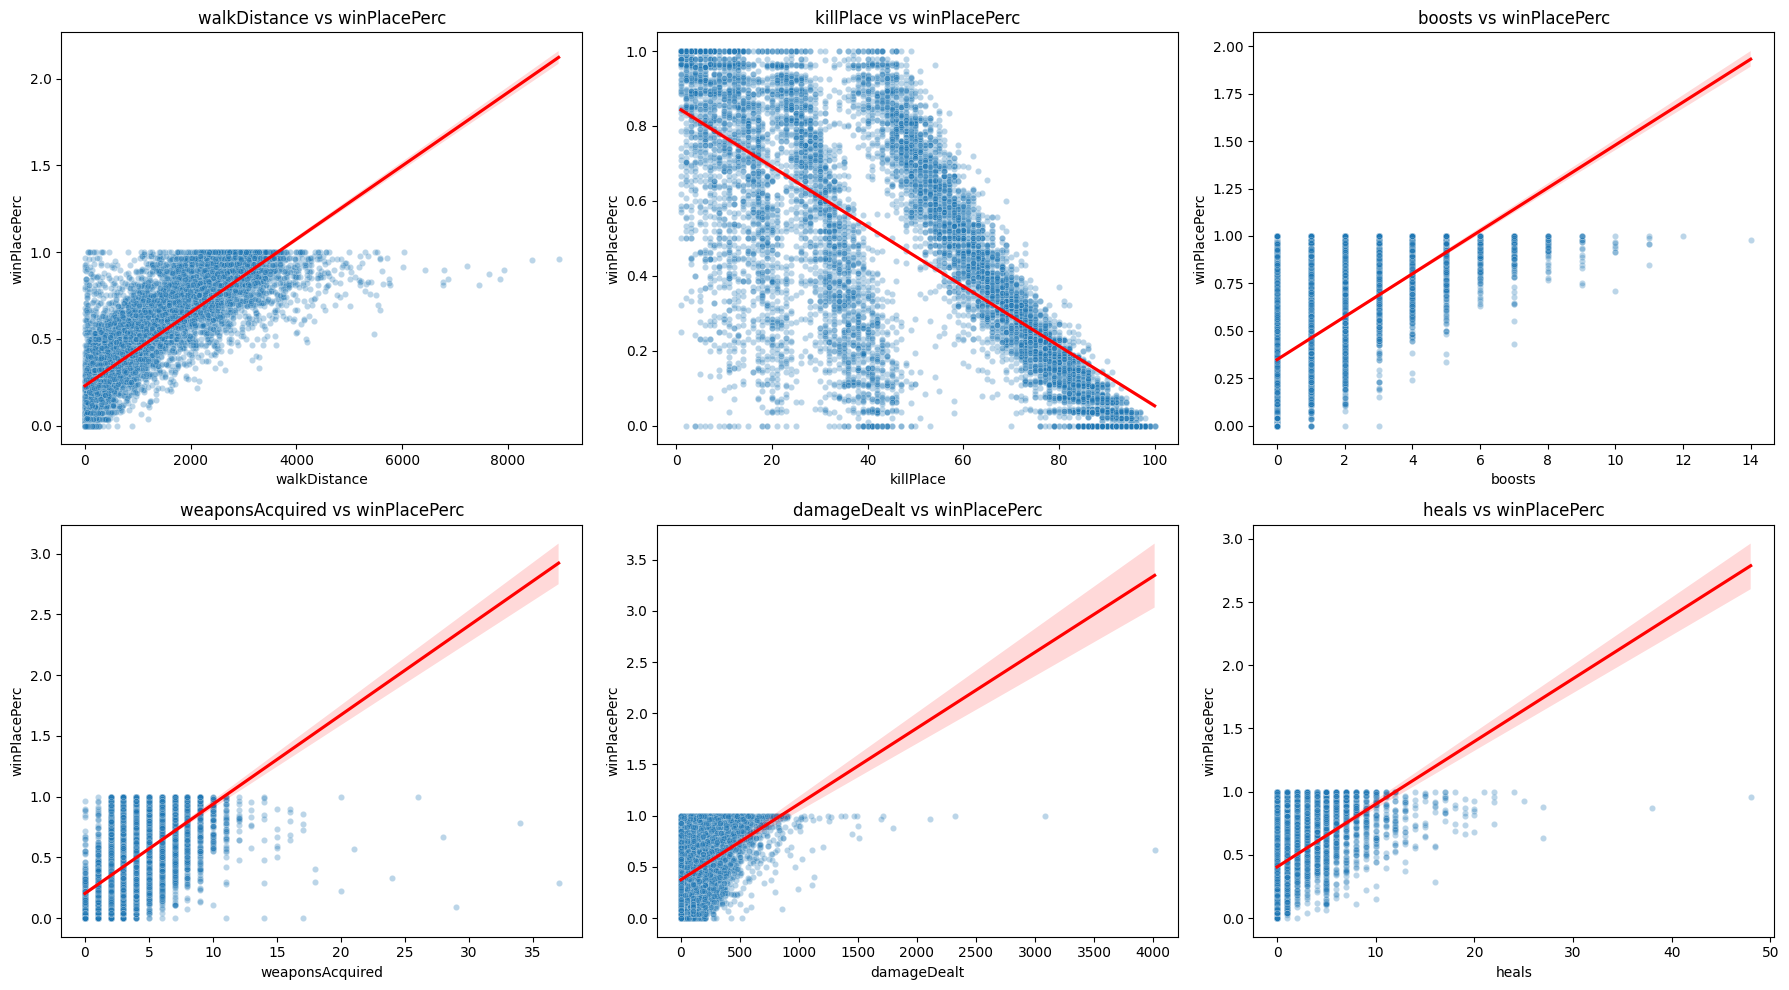

In [17]:
top_features = corr_with_target.index

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, feature in zip(axes.flatten(), top_features):
    sns.scatterplot(
        data=df.sample(10000, random_state=random_state),
        x=feature, y='winPlacePerc',
        alpha=0.3, s=20, ax=ax
    )
    sns.regplot(
        data=df.sample(10000, random_state=random_state),
        x=feature, y='winPlacePerc',
        scatter=False, color='red', ax=ax
    )
    ax.set_title(f'{feature} vs winPlacePerc')
plt.tight_layout()
plt.show()


### Target Variable Exploration

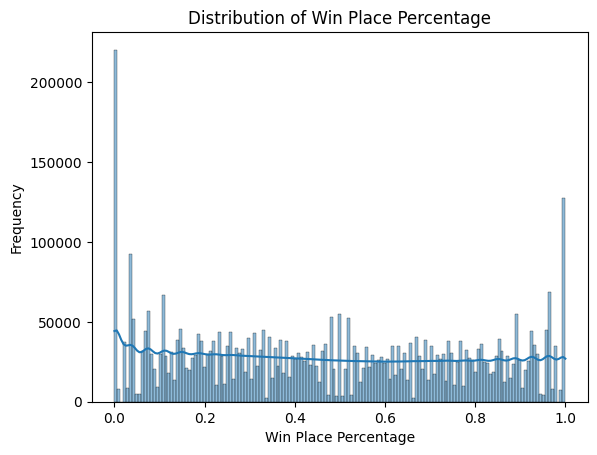

In [13]:
sns.histplot(df['winPlacePerc'], kde=True)
plt.title('Distribution of Win Place Percentage')
plt.xlabel('Win Place Percentage')
plt.ylabel('Frequency')
plt.show()

### Outlier and Data Quality Check

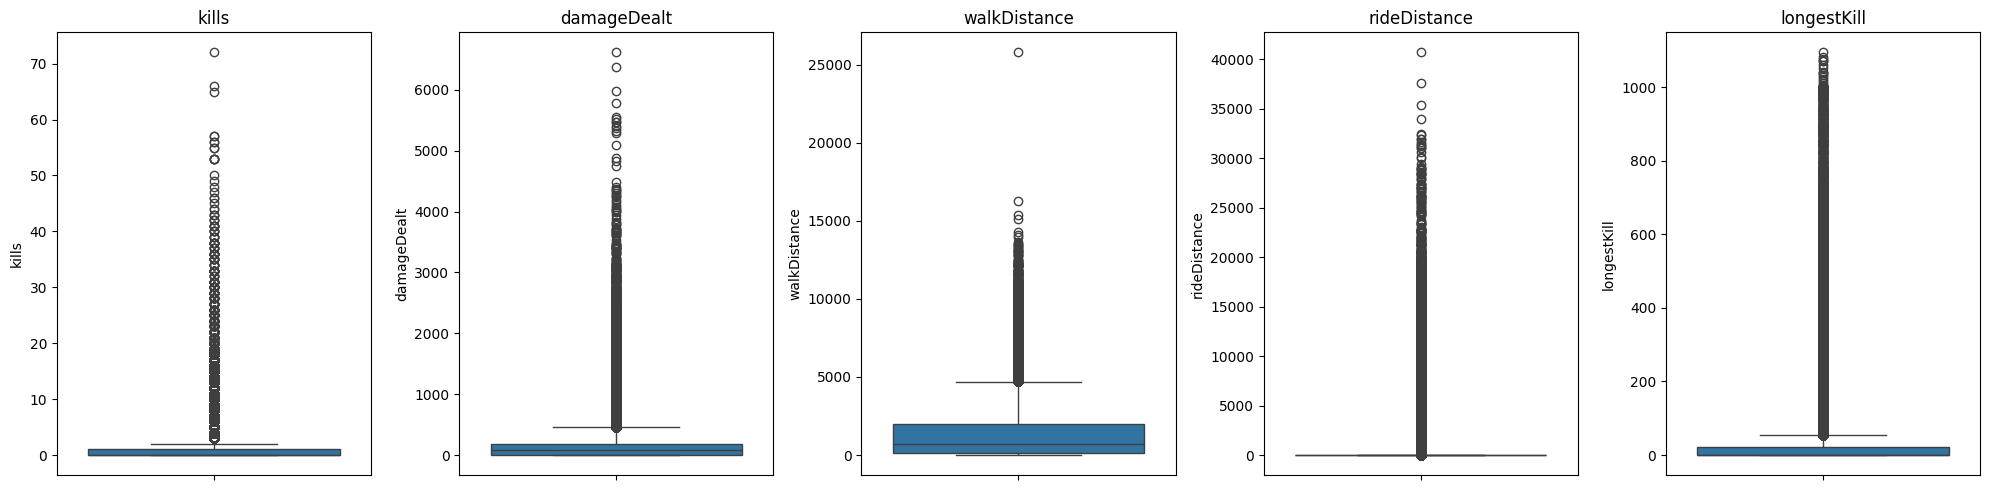

In [19]:
df[num_cols].max().sort_values(ascending=False).head(10)
df[num_cols].min().sort_values().head(10)

# Boxplots for key skewed features
key_features = ['kills', 'damageDealt', 'walkDistance', 'rideDistance', 'longestKill']

fig, axes = plt.subplots(1, len(key_features), figsize=(20, 5))
for ax, feature in zip(axes, key_features):
    sns.boxplot(data=df, y=feature, ax=ax)
    ax.set_title(feature)
plt.tight_layout()
plt.show()


### Multicollinearity Heatmap

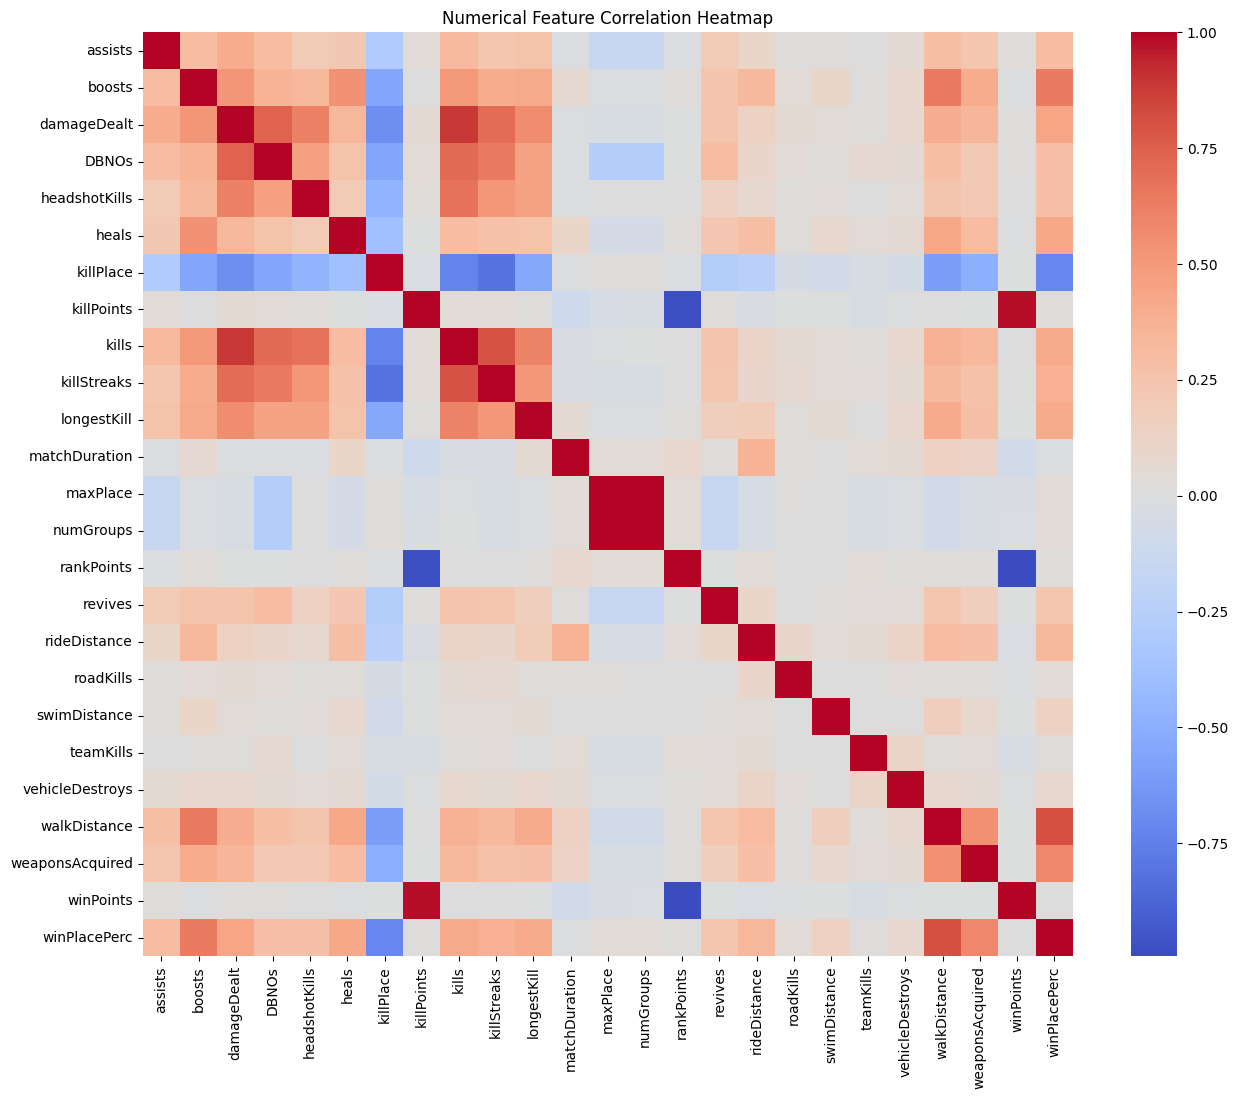

In [14]:
plt.figure(figsize=(15,12))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Numerical Feature Correlation Heatmap')
plt.show()

### Match-Type Stratification

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='matchType', y='winPlacePerc')
plt.xticks(rotation=45)
plt.title('winPlacePerc Distribution by Match Type')
plt.show()

agg_cols = top_features.to_list()
match_summary = df.groupby('matchType')[agg_cols].mean().sort_values(by=agg_cols[0], ascending=False)
match_summary.plot(kind='bar', figsize=(12,6))
plt.title('Mean Feature Values by Match Type')
plt.ylabel('Mean')
plt.show()


### Log-Transform Visualization

In [ ]:
skewed_features = ['walkDistance', 'damageDealt', 'kills']

fig, axes = plt.subplots(2, len(skewed_features), figsize=(15, 8))
for i, feature in enumerate(skewed_features):
    sns.histplot(df[feature], bins=50, ax=axes[0, i], kde=True)
    axes[0, i].set_title(f'{feature} (Original)')
    
    # Log transform safely (add small epsilon to avoid log(0))
    sns.histplot(np.log1p(df[feature]), bins=50, ax=axes[1, i], kde=True, color='orange')
    axes[1, i].set_title(f'{feature} (log1p transformed)')
plt.tight_layout()
plt.show()


### Feature-Target Correlation

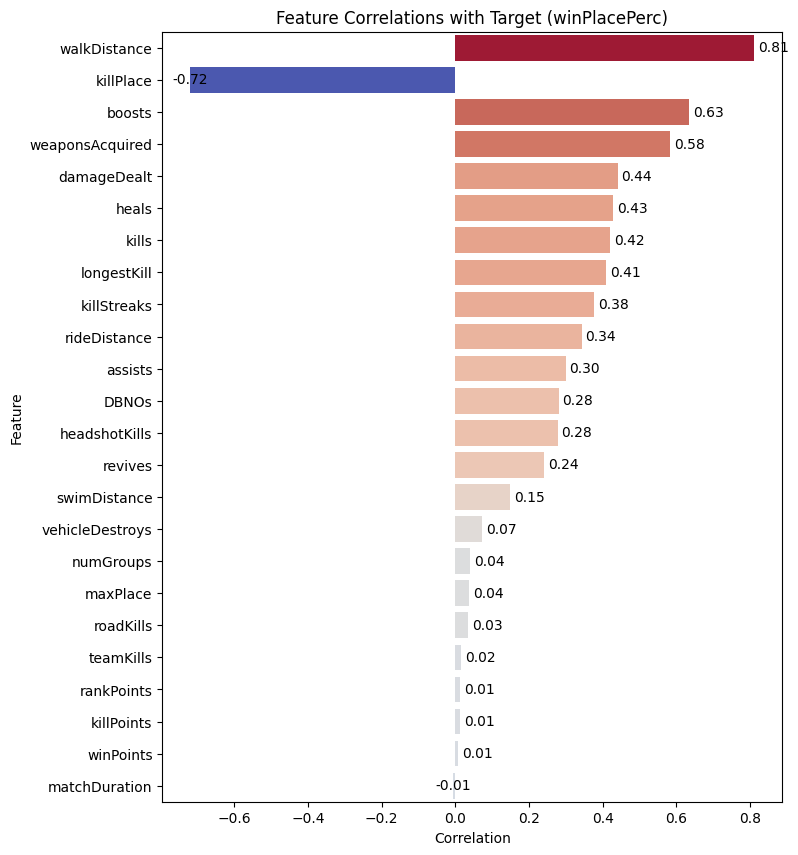

In [15]:
plt.figure(figsize=(8, 10))
sns.barplot(
    x=corr_with_target,
    y=corr_with_target.index,
    palette='coolwarm',
    hue=corr_with_target,
    legend=False
)
for i, v in enumerate(corr_with_target):
    plt.text(v + 0.01 if v > 0 else v - 0.05, i, f"{v:.2f}", color='black', va='center')
plt.title('Feature Correlations with Target (winPlacePerc)')
plt.xlabel('Correlation')
plt.ylabel('Feature')
plt.show()
